# Modeling an HHL algorithm with Classiq: solving a set of linear equations

Solving linear equations appears in all research, engineering, and design areas. For example, many physical and financial models, from fluid dynamics to portfolio optimization, are described by partial differential equations, which are typically treated by numerical schemes--- most of these schemes are eventually transformed to a set of linear equations.

The HHL algorithm [[1](#HHL)] is a quantum algorithm for solving a set of linear equations. It is one of the fundamental quantum algorithms which  is expected to give a speedup over its classical counterpart.


A set of linear equations of size $N$ is represented by an $N\times N$ matrix and a vector $b$ of size $N$,
$$
A\vec{x} = \vec{b},
$$
where the solution to the problem is designated by the solution variable $\vec{x}$.

For simplicity, in the demo below we treat a use-case where $\vec{b}$ is a normalized vector $|\vec{b}|=1$, and $A$ is an Hermitian matrix of size $2^n\times 2^n$, whose eigenvalues are in the interval $(0,1)$. Generalizations to any other use-case are discussed at the end of this demo.

## Definning a specific problem

We start by defining a specific problem.

In [ ]:
import numpy as np

A = np.array(
    [
        [0.28, -0.01, 0.02, -0.1],
        [-0.01, 0.5, -0.22, -0.07],
        [0.02, -0.22, 0.43, -0.05],
        [-0.1, -0.07, -0.05, 0.42],
    ]
)

b = np.array([1, 2, 4, 3])
b = b / np.linalg.norm(b)

print("A =", A, "\n")
print("b =", b)

# verifying that the matrix is symmetric and have eivenvalues in [0,1)
if not np.allclose(A, A.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")
w, v = np.linalg.eig(A)
for lam in w:
    if lam < 0 or lam > 1:
        raise Exception("Eigenvalues are not in (0,1)")

In addition, in the quantum program below we have to encode the unitary matrix $U=e^{iA}$. For this, we will have to decompose the matrix $A$ into a sum of Pauli strings. This is a completely classical pre-processing which we now perform. We use a naive decomposition, more efficient decompositions can be devised.

## Pauli strings decomposition

#### We define the auxiliary function `lcu_naive` for the classical pre-processing: decomposing a matrix into sum of Pauli strings

In [ ]:
from itertools import product

from numpy import kron

Paulidict = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


# generate all combinations of Pauli strings of size n
def generate_all_pauli_strings(seq, n):
    for s in product(seq, repeat=n):
        yield "".join(s)


# convert a Paulistring of size n to 2**n X 2**n matrix
def pauli_string_2mat(seq):
    myPmat = Paulidict[seq[0]]
    for p in seq[1:]:
        myPmat = kron(myPmat, Paulidict[p])
    return myPmat


# Hilbert-Schmidt-Product of two matrices M1, M2
def hilbert_schmidt(M1, M2):
    return (np.dot(M1.conjugate().transpose(), M2)).trace()


# Naive decomposition, running over all HS products for all Pauli strings
def lcu_naive(H):
    assert H.shape[0] == H.shape[1], "matrix is not square"
    assert H.shape[0] != 0, "matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    myPualiList = list(generate_all_pauli_strings("IZXY", n))

    mylist = []

    for pstr in myPualiList:
        co = (1 / 2**n) * hilbert_schmidt(pauli_string_2mat(pstr), H)
        if co != 0:
            mylist = mylist + [(pstr, co)]

    return mylist

#### We now use the auxiliary function to decompose the matrix $A$ in our specific use-case. The variable `paulis` holds the list of Pauli strings that represents our matrix. The number of qubits to represent the matrix is stored in the variable `n`.

In [ ]:
paulis = lcu_naive(A)
n = len(paulis[0][0])
print("Pauli strings list: \n")
for p in paulis:
    print(p[0], ": ", np.round(p[1], 3))

print("\n Number of qubits for matrix representation =", n)

## Modelling an HHL algorithm

Now that we have finished with pre-processing we can turn to defining the HHL algorithm. The algorithm consists of 4 steps:
1) State Preparation of the RHS vector $\vec{b}$.
2) QPE for the unitary matrix $e^{2\pi iA}$, which encodes eigenvalues on a quantum register of size $m$.
3) An inversion algorithm which loads amplitudes according to the inverse of the eigenvalue registers.
4) An inverse QPE with the parameters in (2).

Below we introduce the HHL algorithm step by step. At each step, we describe the relevant quantum function, and define its parameters. In parallel, we also follow the linear algebra which underlies the theory behind the HHL algorithm. Finally, we define the corresponding model, synthesize the circuit, execute it, and verify the results.

### Defining function parameters

#### 1) State Preparation for the vector $\vec{b}$

The first stage of the HHL algorithm is to load the normalized RHS vector $\vec{b}$ into a quantum register:
$$
|0\rangle_n \xrightarrow[{\rm SP}]{} \sum^{2^n-1}_{i=0}b_i|i\rangle_n
$$
where $|i\rangle$ are states in the computational basis.

We thus start with defining a State Preparation function, using Classiq's `StatePreparation`: passing $2^n$ values of $\vec{b}$ as `amplitudes`, as well as an upper bound through `error_metric` for the functional error (since we pass amplitudes, only $L$-norms are relevant here).



In [ ]:
from classiq.builtin_functions import StatePreparation

b_normalized = tuple(b)
sp_upper = 0.00  # precision of the State Preparation
sp = StatePreparation(
    amplitudes=b_normalized, error_metric={"L2": {"upper_bound": sp_upper}}
)

#### 2) Quantum Phase Estimation (QPE) for the Hamiltonian evolution $U=e^{2\pi i A }$

The QPE function block, which is at the heart of the HHL algorithm, operates as follows: Unitary matrices have eigenvalues of norm 1, and thus are of the form $e^{2\pi i \lambda}$, with $0\leq\lambda<1$. If we have a quantum state $|\psi\rangle_n$, prepared in an eigenvalue of some unitary matrix $U$ of size $2^n\times 2^n$, the QPE algorithm encodes the corresponding  eigenvalue into a quantum register:
$$
|0\rangle_m|\psi\rangle_n \xrightarrow[{\rm QPE}(U)]{} |\lambda\rangle_m|\psi\rangle_n,
$$
where $m$ is the precision of the binary representation of $\lambda$, $\lambda=\frac{1}{2^m}\sum^{2^m-1}_{k=0}\lambda^{(k)}2^k$ with $\lambda^{(k)}$ being the state of the $k$-th qubit.

In the HHL algorithm we apply a QPE for the unitary $U=e^{2\pi i A }$. Let us see the mathematics now. First, note that the eigenvectors of $U$ are the ones of our matrix $A$, and that the corresponding eigenvalues $\lambda$ defined for $U=e^{2\pi i A }$ are the eigenvalues of  $A$. Second, we can represent our prepared state in the basis given by the eigenvalues of $A$. This is merely a mathematical transformation, there are not algorithmic considerations here. If the eigenbasis of $A$ is given by the set $\{|\psi_j\rangle_n \}^{2^n-1}_{j=0}$, we can write
$$
\sum^{2^n-1}_{i=0}b_i|i\rangle_n = \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n.
$$
Applying the QPE stage we have
$$
|0\rangle_m \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n \xrightarrow[{\rm QPE}]{}  \sum^{2^n-1}_{j=0}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n.
$$

We now define the parameter of Classiq's QPE function. We pass the following parameters:
* `size`: this defines the number of precision qubits to encode the eigenvalues ($m$ above). We will choose $m=4$.
* `unitary_params`: this is the quantum function (namely the operation $U$) for which we apply the QPE. In our case the quantum function is the Exponentiation function, $U=e^{2\pi i A }$. We use Classiq's `Exponentiation` function for Hamiltonian evolution $e^{-i H t}$, for which we define the following parameters:
    * `pauli_operator` which is the list of Pauli strings representing our matrix $H$, taken as the `paulis` variable calculated above.
    * `evolution_coefficient` representing $t$, taken to be $-2\pi$.
* `exponentiation_specification`: this is a unique parameter when calling QPE with Classiq's `Exponentiation` function. The Exponentiation function is an approximated one, where one way to control its error is by limiting its depth. For a QPE algorithm with `size` $m$ a series of controlled-unitaries $U^{2^s}$ $1 \leq s \leq m$ are applied, for each of which we would like to pass a different maximal depth (to keep a roughly same error, the depth of $U=e^{2\pi i 2^s A }$ is expected to be $\sim 2^s$ larger then the depth of $U=e^{2\pi i A }$). In Classiq this can be done by passing `exponentiation_specification` with the following:
    * `max_depth`: setting the maximal depth for the first unitary
    * `max_depth_scaling_factor`: the factor by which the maximal depth of the following Exponentiations will grow.

    (Alternatively, one can also send a specific choice of $m$ max_depth parameters)


In [ ]:
from classiq.builtin_functions import Exponentiation, PhaseEstimation
from classiq.builtin_functions.exponentiation import PauliOperator
from classiq.builtin_functions.qpe import (
    ExponentiationScaling,
    ExponentiationSpecification,
)

m = 4


po = PauliOperator(pauli_list=paulis)
exp_params = Exponentiation(
    pauli_operator=po,
    evolution_coefficient=-2 * np.pi,
)

qpe = PhaseEstimation(
    size=m,
    unitary_params=exp_params,
    exponentiation_specification=ExponentiationSpecification(
        scaling=ExponentiationScaling(max_depth=100, max_depth_scaling_factor=2)
    ),
)

#### 3) Eigenvalue inversion

The next step in the HHL algorithm is to pass the inverse of the eigenvalue registers into their amplitudes. For this, we use the AmplitudeLoading (AL) function.
Given a function $f:[0,1)\rightarrow [-1,1]$, it implements $|0\rangle|\lambda\rangle_m \xrightarrow[{\rm AL}(f)]{} f(\lambda)|1\rangle|\lambda\rangle_m+\sqrt{1-f^2(\lambda)}|0\rangle|\lambda\rangle_m$. For the HHL algorithm we thus apply an AL with $f=C/x$ where $C$ is a lower bound for the minimal eigenvalue of $A$.
Applying this AL we have
$$
\sum^{2^n-1}_{j=0}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n \xrightarrow[{\rm AL}(C/x)]{}
|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)+
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)
$$


Let us now define the parameters for Classiq's `AmplitudeLoading` function:
* `size`: must be taken as $m$ in our case.
* `expression`: describing $f$, and taken as C/x in our case.
* `implementation`: Classiq's support different implementation for AmplitudeLoading, we choose a `GrayCode` implementation.

In [ ]:
from classiq.builtin_functions import AmplitudeLoading
from classiq.builtin_functions.amplitude_loading import AmplitudeLoadingImplementation

w_min = (
    1 / 2**m
)  # for qpe register of size m, this is the minimal value which can be encoded
expression = f"{w_min}/(x)"
al_params = AmplitudeLoading(
    size=m,
    expression=expression,
    implementation=AmplitudeLoadingImplementation.GRAYCODE,
)

#### 4) Inverse QPE

As a final step in the HHL model, we clean the QPE register by applying an inverse-QPE (note that it is not guaranteed that this register is completely cleaned, namely that all the qubits in the QPE register return to zero after the inverse-QPE. Generically they are all zero with very high probability).

In our model we will simply call the QPE function with the same parameters in stage 2, but with the flag `is_inverse`. This will be done when we wire the model below. Let us see how the quantum state looks now
$$
 |0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)+
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j |\lambda_j\rangle_m |\psi_j\rangle_n\right)
\xrightarrow[{\rm inv-QPE}(U)]{}
 |0\rangle_m|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\lambda^2_j}}\beta_j  |\psi_j\rangle_n\right)+
|0\rangle_m|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\lambda_j}\beta_j  |\psi_j\rangle_n\right)
$$

One can see that the state entangled with $|1\rangle$ stores the solution to our problem (up to some normalization problem)
$$
\sum^{2^n-1}_{j=0} \frac{C}{\lambda_j}\beta_j  \vec{\psi_j} = C\vec{x}
$$


### Wiring the model and defining its outputs: a register of size `nq` for the solution and the target qubit

In this tutorial we will compare between the classical and quantum solutions, thus we we will execute the resulting circuit on a statevector simulator. To define this part of our model we set `Sample` and `ExecutionPreferences` of a statevector simulator.

In [ ]:
from classiq import Model
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences

model_hhl = Model()
sp_out = model_hhl.StatePreparation(params=sp)
qpe_out = model_hhl.PhaseEstimation(params=qpe, in_wires={"IN": sp_out["OUT"]})
al_out = model_hhl.AmplitudeLoading(
    params=al_params,
    in_wires={"AMPLITUDE": qpe_out["PHASE_ESTIMATION"]},
)
i_qpe_out = model_hhl.PhaseEstimation(
    params=qpe,
    is_inverse=True,
    release_by_inverse=True,
    in_wires={
        "PHASE_ESTIMATION": al_out["AMPLITUDE"],
        "OUT": qpe_out["OUT"],
    },
)

model_hhl.sample()

model_hhl.set_outputs({"target": al_out["TARGET"], "solution": i_qpe_out["IN"]})

backend_preferences = ClassiqBackendPreferences(
    backend_name="aer_simulator_statevector"
)

qmod_hhl = model_hhl.get_model()

qmod_hhl = set_execution_preferences(
    qmod_hhl,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)

In [ ]:
with open("hhl.qmod", "w") as f:
    f.write(qmod_hhl)

#### Synthesizing the circuit

In [ ]:
from classiq import synthesize

qprog_hhl = synthesize(qmod_hhl)

In [ ]:
from classiq import show

show(qprog_hhl)

In [ ]:
from classiq import GeneratedCircuit

circuit_hhl = GeneratedCircuit.from_qprog(qprog_hhl)
print("depth = ", circuit_hhl.transpiled_circuit.depth)

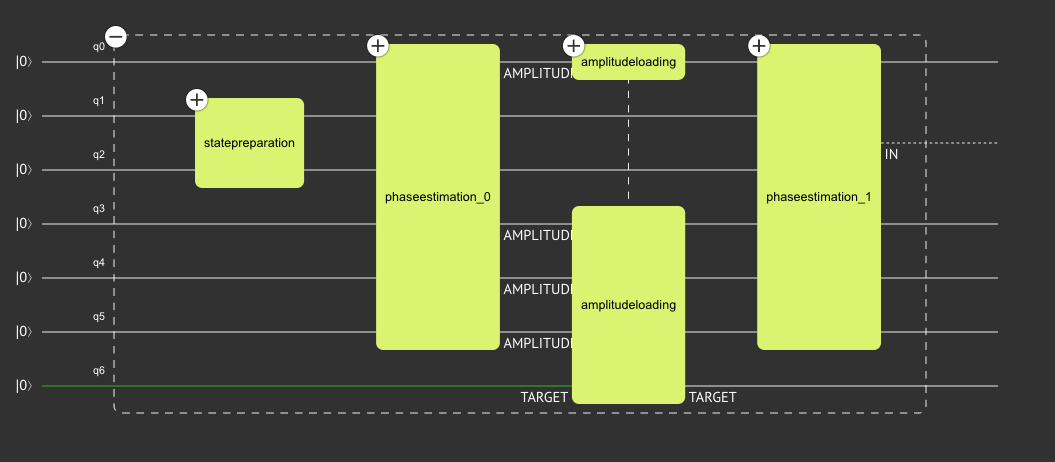

### Execution and verification of the result (through statevector simulator)

#### We now execute the quantum program. Recall that we chose here a statevector simulator since we are interested in the exact solution

In [ ]:
from classiq import execute

results = execute(qprog_hhl).result()

In [ ]:
from classiq.execution import ExecutionDetails

res_hhl = results[0].value

#### Next we read the specific results, given in the `solution` register defined in our model, where we care only for entries where the `target` register is 1.

In [ ]:
total_q = circuit_hhl.data.width  # total number of qubits of the whole circuit

We read the qubit allocation of the relevant registers.

In [ ]:
target_pos = res_hhl.physical_qubits_map["target"][0]  # position of control qubit

sol_pos = list(res_hhl.physical_qubits_map["solution"])  # position of solution

phase_pos = [
    total_q - k - 1 for k in range(total_q) if k not in sol_pos + [target_pos]
]  # finds the position of the “phase” register, and flips for endianness as we will use the indices to read directly from the string

We define a run over all the relevant strings holding the solution. The solution vector will be inserted into the variable `qsol`. We also factor out $C=1/2^m$.

In [ ]:
qsol = [
    np.round(parsed_state.amplitude / w_min, 5)
    for solution in range(2**n)
    for parsed_state in res_hhl.parsed_state_vector
    if parsed_state["target"] == 1.0
    and parsed_state["solution"] == solution
    and [parsed_state.bitstring[k] for k in phase_pos]
    == ["0"] * m  # this takes the entries where the “phase” register is at state zero
]

#### Comparing classical and quantum solutions.

Note that the HHL algorithm returns a statevector result up to some global phase (coming from transpilation or from the quantum functions themselves). Therefore, for comparing with the classical solution we must correct for this global phase.

In [ ]:
sol_classical = np.linalg.solve(A, b)
global_phase = np.angle(qsol)
qsol_corrected = np.real(qsol / np.exp(1j * global_phase))
print("classical:  ", sol_classical)
print("HHL:        ", qsol_corrected)
print(
    "relative distance:  ",
    round(
        np.linalg.norm(sol_classical - qsol_corrected)
        / np.linalg.norm(sol_classical)
        * 100,
        1,
    ),
    "%",
)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sol_classical, "bo", label="classical")
plt.plot(qsol_corrected, "ro", label="HHL")
plt.legend()
plt.xlabel("$i$")
plt.ylabel("$x_i$")
plt.show()

### This is to verify that there is no functional error, which might come from changing endianness in Model or Execution, or in some function params

In [ ]:
if np.linalg.norm(sol_classical - qsol_corrected) / np.linalg.norm(sol_classical) > 0.1:
    raise Exception(
        "The HHL solution is too far from the classical one, please verify your algorithm"
    )

## Generalizations

The use-case treated above is a canonical one, assuming the following properties:
1) The RHS vector $\vec{b}$ is normalized.
2) The matrix $A$ is an Hermitian one.
3) The matrix $A$ is of size $2^n\times 2^n $.
4) The eigenvalues of $A$ are in the range $(0,1)$.

However, any general problem which does not follow these conditions can be resolved as follows:

1) As a preprocessing we can normalize $\vec{b}$ and then return the normalization factor as a post-processing
2) We can symmetrize the problem as follows:
$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{x}
\end{pmatrix}.
$$
This increases the number of qubits by 1.
3) We can complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ will be completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$
4) Let us assume that the eigenvalues of $A$ are in the range $[-w_{\min},w_{\max}]$. The idea is to employ transformations to the exponentiated matrix that enters into the Hamiltonian simulation, and then undo them for extracting the results:
$$
\tilde{A}=(A+w_{\min}I)\left(1-\frac{1}{2^{m}}\right)\frac{1}{w_{\min}+w_{\max}}.
$$
The eigenvalues of this matrix lay in the interval $[0,1)$, and are related to the eigenvalues of the original matrix via
$$
\lambda = (w_{\min}+w_{\max})\tilde{\lambda}\left[1/\left(1-\frac{1}{2^{n_{m}}}\right)\right]-w_{\min},
$$
with $\tilde{\lambda}$ being an eigenvalue of $\tilde{A}$ resulting from the QPE algorithm. This relation between eigenvalues is then used for the expression inserted into the eigenvalue inversion, via the `AmplitudeLoading` function.

## References

<a name='HHL'>[1]</a>: [Harrow, A. W., Hassidim, A., & Lloyd, S., Quantum Algorithm for Linear Systems of Equations. Physical Review Letters 103, 150502 (2009)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502)
